In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report,confusion_matrix
import torch
from abc import ABC,abstractmethod

## DATASET PREP

In [218]:
#import data
def getAllPaths(path:str, excludeList = []):
    path = path
    pathList = []
    labelList = []
    dirList = os.listdir(path)[:3]
    for idx, x in enumerate(dirList):
        for xx in os.listdir(f"{path}/{x}"):
            if not any(xxx in xx for xxx in excludeList):
                pathList.append(f"{path}/{x}/{xx}")
                labelList.append(idx)
    return pathList, labelList

trainPathFull = r".\ExperimentSet"
trainPathRaw = r".\ExperimentSetRaw"
trainPathSeg = r".\ExperimentSetNoFlip"

valPath = r".\ValidationSet"
originalPath = r".\Osteoporosis Knee X-ray"

trainPathListRaw,trainLabelListRaw = getAllPaths(trainPathRaw)
trainPathListSeg,trainLabelListSeg = getAllPaths(trainPathSeg)
trainPathListFlip,trainLabelListFlip = getAllPaths(trainPathFull,['Rp','Rn','Sup','Sdown','Sleft','Sright'])
trainPathListAug,trainLabelListAug = getAllPaths(trainPathFull)
# trainPathListRotate,trainLabelListRotate = getAllPaths(trainPathFull,['Rp','Rn'])

valPathList,valLabelList = getAllPaths(valPath)
originalPathList,originalLabelList = getAllPaths(originalPath)

trainDirList = os.listdir(trainPathFull)[:3]
valDirList = os.listdir(valPath)[:3]
print(trainPathListAug[:5])

['.\\ExperimentSet/normal/N10.jpg', '.\\ExperimentSet/normal/N100.jpg', '.\\ExperimentSet/normal/N100Rn.jpg', '.\\ExperimentSet/normal/N100Rp.jpg', '.\\ExperimentSet/normal/N100Sdown.jpg']


In [219]:
#check val distribution (this should be 10,10,10)
#this does not account for excluded names
trainDist = []
for idx,x in enumerate(valDirList):
    print(f"val {x}: {len(os.listdir(f'{valPath}/{x}'))}")

for idx,x in enumerate(trainDirList):
    print(f"train {x}: {len(os.listdir(f'{trainPathFull}/{x}'))}")
    
    trainDist.append(len(os.listdir(f'{trainPathFull}/{x}')))

val normal: 10
val osteopenia: 10
val osteoporosis: 10
train normal: 315
train osteopenia: 1645
train osteoporosis: 455


In [ ]:
#check image sizes
from PIL import Image
imageSizes = {}
for x in trainPathListSeg:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

In [220]:
df = pd.read_excel("Osteoporosis Knee X-ray/patient details.xlsx")
df.columns

Index(['S.No', 'Patient Id', 'Joint Pain:', 'Gender', 'Age', 'Menopause Age',
       'height  (meter)', 'Weight (KG) ', 'Smoker', 'Alcoholic', 'Diabetic',
       'Hypothyroidism', 'Number of Pregnancies', 'Seizer Disorder',
       'Estrogen Use', 'Occupation ', 'History of Fracture', 'Dialysis:',
       'Family History of Osteoporosis', 'Maximum Walking distance (km)',
       'Daily Eating habits', 'Medical History', 'T-score Value',
       'Z-Score Value', 'BMI: ', 'Site', 'Obesity', 'Diagnosis'],
      dtype='object')

# DataLoader & Transforms

In [204]:
import torch.utils
import torchvision
import torch
import torchvision.transforms.functional as vF
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None): 
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx):
        try:
            image = Image.open(self.itemsPath[idx]).convert('RGB')
        except Exception as e:
            print(idx)
            print(self.itemsPath)
            raise e
        if self.transform:
            image = self.transform(image)  
        
        image.to(device = torch.device('cuda'))

        return image, self.labels[idx], self.itemsPath[idx]       

class OsteoSetWithPatientDetails(torch.utils.data.Dataset): #ONLY WORKS WITH SEGMENTED IMAGES with extra digit at the back
    def __init__(self, itemsPath:list, labels:list, transform=None): 
        
        df = pd.read_excel("Osteoporosis Knee X-ray/patient details.xlsx")
        
        bmi = df.columns[-4]
        
        df = df[['Patient Id',
                 'Gender',
                 'Age',
                 'Weight (KG) ',
                 bmi]]
        df = df.dropna()
        df.reset_index(drop=True,inplace=True)
        df.Gender = df.Gender.apply(lambda x: 1 if x == 'male' else 0)
        # df['Family History of Osteoporosis'] = df['Family History of Osteoporosis'].apply(lambda x: 1 if x == 'yes' else 0)
        df['Age'] = ((df['Age']/df['Age'].mean())*2)-1
        df['Weight (KG) '] = ((df['Weight (KG) ']/df['Weight (KG) '].mean())*2)-0.1
        df[bmi] = ((df[bmi]/df[bmi].mean())*2) - 1
        df[df['Patient Id'] == 'N12']

        words = [x.split(r'/')[-1].split(r'.')[0] for x in itemsPath]
        augments = ['Rp','Rn','Sup','Sdown','Sleft','Sright']
        for x in augments:
            words = [w.replace(x,'') for w in words]
        pathNames = [x[:-1] for x in words]

        for i in range(len(pathNames)):
            pathNames[i] = df[df['Patient Id'] == pathNames[i]].to_numpy()
            pathNames[i] = list(np.append(pathNames[i],itemsPath[i]))

        
        self.itemsPath = pathNames
        self.labels = labels
        self.transform = transform
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        try:
            image = Image.open(self.itemsPath[idx][-1]).convert('RGB')
        except Exception as e:
            print(idx)
            print(self.itemsPath)
            raise e
        
        if self.transform:
            image = self.transform(image)  
        
        image.to(device = torch.device('cuda'))

        # last element returned is Gender, Age, Weight, Family History
        return [image,torch.tensor(self.itemsPath[idx][1:-1],dtype=torch.float16)], self.labels[idx], self.itemsPath[idx][-1]
                    

#inits dataset and dataloader + resamples training data to balance classes
def balanceSet(trainPathList,trainLabelList,transform,replacement = False,offset = 3,batchSize = 10,dataset = None):
    if isinstance(dataset,OsteoSetWithPatientDetails): 
        trainDataset = dataset
    else:
        trainDataset = OsteoTorchDataset(trainPathList,trainLabelList,transform)    
          
    unique_elements, counts = torch.unique(torch.tensor(trainLabelList), return_counts=True)
    sampleWeights = 1. / counts.float() #I HAVE NO IDEA WHY THIS WORKS BUT IT DOES
    # MORAL OF THE STORY: FOLLOW THE FUCKING TUTORIAL DONT TRY CHANGING SHIT ON YOUR OWN ***EVEN IF THE DOCUMENTATION SAYS YOU SHOULD***
    # trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabelList],num_samples=len(trainDataset),replacement=True)

    # trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabelList],num_samples=min(trainDist)*8,replacement=False)

    trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabelList],num_samples=counts.min().item()*(3+offset),replacement= replacement)

    trainLoader = DataLoader(trainDataset, batch_size = batchSize,shuffle=False,num_workers=0,sampler=trainSampler)
    return trainLoader

In [205]:
# # Code to save Processed images to disk to save on processing time
# import PIL
# # trainDataset = OsteoTorchDataset(trainPathList,trainLabelList,transformCenter)

# valDataset = OsteoTorchDataset(valPathList,valLabelList,transformCenter)
# for x in valDataset:
#     arr = ((x[0].permute(1,2,0)*255).numpy().astype(np.uint8))
#     img = PIL.Image.fromarray(arr,mode="RGB")
#     img.save(x[2].replace('ValidationSet','ValidationSet copy'))

## Visualization (can skip this)

In [206]:
transformNone = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((224,224)),
                                            # torchvision.transforms.CenterCrop((224,224)),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])                      

valTransform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])   

transformCenter = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((269,269)),
                                            torchvision.transforms.CenterCrop((224,224)),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])                      

In [207]:
trainLoader = balanceSet(trainPathListAug,trainLabelListAug,transformCenter)

valDataset = OsteoTorchDataset(valPathList,valLabelList,valTransform)
valLoader = DataLoader(valDataset, batch_size = 8,shuffle=False,num_workers=0)

unique_elements, counts = torch.unique(torch.cat([y for x,y,z in trainLoader]), return_counts=True)#delete this
counts

tensor([ 315, 1130,  445])

In [208]:
unique_elements, counts = torch.unique(torch.cat([x for y,x,z in valLoader]), return_counts=True)#delete this
counts

tensor([10, 10, 10])

In [209]:
temp = next(iter(trainLoader))
index = -1

temp[0][0].max()

tensor(0.8273)

210
.\ExperimentSet/normal/N71Sup.jpg


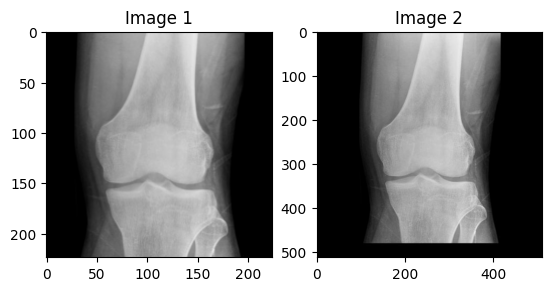

In [210]:
# temp[0][0].min()

import matplotlib.pyplot as plt
index += 1
# print(temp[1][index],temp[2][index])
print((temp[0][index].numpy()*255).max().astype(np.uint8))

fig, axs = plt.subplots(1, 2)

print(str(temp[2][index]))
# Plot the first image
axs[0].imshow(((temp[0][index]+1)/2).permute(1, 2, 0))
axs[0].set_title('Image 1')

# Plot the second image
axs[1].imshow(Image.open(temp[2][index]).convert('RGB'))
axs[1].set_title('Image 2')

plt.show()

## MODEL PREP


In [211]:
# import models here
import sklearn.metrics
from resnetModel import ResNet50
import sklearn
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
import cv2
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns
from abc import ABC
import typing

#FIXME clean up my fucking code ffs its so UGLY

class ExperimentModel(L.LightningModule,ABC):

    existingModels = []

    def __init__(self) -> None:
        ExperimentModel.existingModels.append(self)
        super().__init__()

        #init the models here in a subclass
        self.name = self.__class__.__name__
        self.num_class = 3
        self.classWeight = torch.tensor([0.204, 0.052, 0.175],device='cuda')
        self.LOGPATH = None
        self.trainLoader = None
        self.valLoader = None
        
        # if (torch.tensor([0.204, 0.052, 0.175],device='cuda')*0).detach()[0].item() == 0:
        #   self.classWeight = torch.ones(self.classWeight.size(),device='cuda')

        self.dump = []

    def setLogPath(self,logPath): # this should be the general logging dir of the model's current version (refer to tblogger in training loop)
        self.LOGPATH = logPath
    
    def setDataLoader(self,trainLoader:typing.Optional[DataLoader] = None,valLoader:typing.Optional[DataLoader] = None):
        self.trainLoader = trainLoader
        self.valLoader = valLoader  
    
    @abstractmethod
    def forward():
        pass
    
    def training_step(self,batch):
        data,label,path = batch

        output = self(data)
        self.dump.append([path,label])
        # loss = F.cross_entropy(output,label,weight=self.classWeight)
        loss = F.cross_entropy(output,label)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", multiclass_accuracy(output.argmax(1),label,num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        pass
        # f1 macro and accuracy logs have been moved to GradCamTrak

        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        return optimizer

    def test_step(self,batch, batch_idx):
        self.validation_step(batch,batch_idx)

In [212]:
import functools
import re
import io

import torchvision.transforms.functional
import resnetModel
import shutil

class GradCamTrack(ExperimentModel): #Class for GradCam visualization, should be subclassed by the model to be visualized with a new init and a forward + hook
    
    def __init__(self,) -> None:
        super().__init__()
        
        self.gradients = None
        self.cachedActivation = None

    # cachedActivation is no longer needed, but kept for legacy purposes
    def activations_hook(self, grad, imageActivation = None):
        if imageActivation != None:
            self.cachedActivation = imageActivation
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x.to(device = torch.device('cuda')))
     
    # Runs CAM and overlays the image
    # this is the function to call for visualization
    def visualize(self,dataloader:torch.utils.data.dataloader.DataLoader): #TODO FIX THIS for generalization
        
        with torch.inference_mode(False):
            out,path,pred = self.CAM(dataloader)
        
        #visualize saves the images in 2 locations, one for the current epoch(same path as logdir) and one for the latest model (visualizations/gradCam)
       
        try:
            os.mkdir(rf'./{self.LOGPATH}/gradCam')
        except OSError:
            pass

        try:
            shutil.rmtree(rf'./{self.LOGPATH}/gradCam/{self.current_epoch}')
        except FileNotFoundError:
            pass
        
        os.mkdir(rf'./{self.LOGPATH}/gradCam/{self.current_epoch}')

        for i in range(len(out)):
            self.visualizeAndWrite(out[i],path[i],pred[i],rf'./{self.LOGPATH}/gradCam/{self.current_epoch}')
        return pred,path
    
    # Visualizes the Gradients of the last conv layer of model
    # can take in torch dataloader or ([img],[label],[path])
    def CAM(self,dataloader:torch.utils.data.dataloader.DataLoader):
        
        self.eval()
        self.requires_grad_()
        predList = []

        pathList = []
        
        heatmapList = []

        for x in dataloader:
            if isinstance(dataloader.dataset,OsteoSetWithPatientDetails):
                img,label,path = x
            else:
                img,label,path = x
                img = [img]

            
            for x in img:
                x = x.to(device = torch.device('cuda'))
                
            for i in range(len(img[0])):
                if isinstance(dataloader.dataset,OsteoSetWithPatientDetails):
                    temp = [torch.unsqueeze(img[0][i],0),torch.unsqueeze(img[1][i],0)]
                    [x.requires_grad_() for x in temp]
                    out = self(temp)
                else:
                    out = self(torch.unsqueeze(img[0][i],0).requires_grad_())
                pred = out.argmax(1).item()
                predList.append(pred)
                # get the gradient of the output with respect to the parameters of the model
                out[:, pred].backward()

                # pull the gradients out of the model
                gradients = self.get_activations_gradient()

                # pool the gradients across the channels
                pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

                # get the activations of the last convolutional layer
                if self.cachedActivation != None:
                    activations = self.cachedActivation.detach()
                else:
                    activations = self.get_activations(torch.unsqueeze(img[0][i],0)).detach() # DONT forget to apply image changes here too
                # weight the channels by corresponding gradients
                for j in range(pooled_gradients.shape[0]):
                    activations[:, j, :, :] *= pooled_gradients[j]
                    
                # average the channels of the activations
                heatmap = torch.mean(activations, dim=1).squeeze()

                # relu on top of the heatmap
                # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
                heatmap = np.maximum(heatmap.detach().cpu(), 0)

                # normalize the heatmap
                heatmap /= torch.max(heatmap)

                # draw the heatmap
                heatmapList.append(heatmap)
                
                pathList.append(path[i])

                self.zero_grad()

        return heatmapList,pathList,predList
    

    #writes files to disk for visualization, format: model_epoch_label_pred/image.jpg
    #logPath should be the "{logging directory of the model}/gradCam/epoch"
    def visualizeAndWrite(self,out:torch.tensor,path:str,pred:str,logPath:str): #TODO Implement this with logger

        labelDict = {0:'N',1:'OP',2:'OS'}
            
        img = cv2.imread(path)
        heatmap = cv2.resize(out.numpy(), (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        # print(max(heatmap.flatten()),min(heatmap.flatten()))
        superimposed_img = heatmap * 0.4 + img
        # superimposed_img = superimposed_img / np.max(superimposed_img)
        # self.logger.experiment.add_image(f'{path.split(r"/")[-1]}',superimposed_img,self.current_epoch,dataformats = 'HWC')
        cv2.imwrite(rf'{logPath}/pred{labelDict[pred]}_{path.split(r"/")[-1].split(r".")[0]}.jpg', superimposed_img)

    def on_validation_epoch_end(self) -> None:
        super().on_validation_epoch_end()
        pred,path = self.visualize(self.valLoader)
        label = [x.split(r"/")[-2] for x in path]
        labelDict = {'normal':0,'osteopenia':1,'osteoporosis':2}
        
        label = [labelDict[x] for x in label]
        # self.log("classification report",classification_report(label,pred))
        print(classification_report(label,pred))
        
        self.log("val_acc_F1_macro", sklearn.metrics.f1_score(label,pred,labels = range(self.num_class),average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", multiclass_accuracy(torch.tensor(pred),torch.tensor(label),num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)

        plt.clf()
        cm= confusion_matrix(label,pred,labels=[0,1,2],normalize='true')
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',vmax=1,vmin=0)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        # plt.axis('off')
        # plt.savefig("out.png",bbox_inches='tight',pad_inches=0)
        # fig = plt.gcf()

        buf = io.BytesIO()
        plt.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)

        # img = Image.frombytes('RGB', 
        #     fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    
        img.save(rf'{self.LOGPATH}/gradCam/{self.current_epoch}/confusionMatrix.PNG')

        grid = torchvision.utils.make_grid(torchvision.transforms.functional.pil_to_tensor(img)) 
        self.logger.experiment.add_image('Confusion Matrix',grid,self.current_epoch)
        # self.log({'Confusion Matrix': plt.gcf()}) #watch out for BUG

    
    def on_test_epoch_end(self)->None:
        self.on_validation_epoch_end()

In [213]:

class VGGModel(GradCamTrack):
    def __init__(self,vgg:torchvision.models.vgg.VGG) -> None:
        super().__init__()
        self.features_conv = vgg.features[:-1]
        # get the max pool of the features stem
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = vgg.classifier
        self.classifier[6] = torch.nn.Linear(4096,self.num_class)


    def forward(self,inTensor):
        x = self.features_conv(inTensor)
        
        # # register the hook
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.max_pool(x)
        x = x.flatten(1,-1)
        x = self.classifier(x)
        return x
    
class VGGModeWithDetails(GradCamTrack):
    def __init__(self,vgg:torchvision.models.vgg.VGG) -> None:
        super().__init__()
        self.features_conv = vgg.features[:-1]
        # get the max pool of the features stem
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = vgg.classifier
        self.classifier[6] = torch.nn.Linear(4096,128)

        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(132,1024),
            torch.nn.ELU(),
            torch.nn.Linear(1024,1024),
            torch.nn.ELU(),
            torch.nn.Linear(1024,128),
            torch.nn.ELU(),
            torch.nn.Linear(128,self.num_class)
        )

    def forward(self,inTensor):
        x = self.features_conv(inTensor[:][0].to(device = torch.device('cuda')))
        
        # # register the hook
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.max_pool(x)
        x = x.flatten(1,-1)
        x = self.classifier(x)
        x = self.MLP(torch.cat([x,inTensor[:][1].to(device=torch.device('cuda'))],dim=1))
        return x

class ResnetModel(GradCamTrack):
    def __init__(self,resnet:torchvision.models.resnet.ResNet) -> None:
        super().__init__()
        self.features_conv = torch.nn.Sequential(*[x for x in resnet.children()][:-2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fc = torch.nn.Linear(2048, self.num_class)
        # self.model.layer4[2] = resnetModel.CustBottleneck(2048,512,self.activations_hook)
        # self.model.fc = torch.nn.Linear(2048,3)
        
    def forward(self,inTensor:torch.tensor):
        x = self.features_conv(inTensor)
        
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

class EfficientNetModel(GradCamTrack):
    
    def __init__(self,effNet:torchvision.models.efficientnet) -> None:
        super().__init__()
        self.features_conv = effNet.features
        self.avgpool = effNet.avgpool
        self.classifier = effNet.classifier
        self.classifier[1] = torch.nn.Linear(1280,self.num_class)
        
        
    def forward(self,inTensor:torch.tensor):
        x = self.features_conv(inTensor)
        
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Model Run

In [214]:
transformNone = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((224,224)),
                                            # torchvision.transforms.CenterCrop((224,224)),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])                      

valTransform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])   


transformCenter = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((269,269)),
                                            torchvision.transforms.CenterCrop((224,224)),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])                      

In [ ]:
# Init models here

valDataset = OsteoTorchDataset(valPathList,valLabelList,valTransform)
valLoader = DataLoader(valDataset, batch_size = 8,shuffle=False,num_workers=0)

ExperimentModel.existingModels = []

# resnet101 = ResnetModel(torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True))
# resnet101.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformNone,replacement=True,offset=6,batchSize = 32),valLoader)
# resnet101.name = 'Resnet50Raw'

# resnet102 = ResnetModel(torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True))
# resnet102.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformNone,replacement=True,offset=6,batchSize = 32),valLoader)
# resnet102.name = 'Resnet50Seg'

# resnet103 = ResnetModel(torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True))
# resnet103.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformNone,replacement=True,offset=6,batchSize = 32),valLoader)
# resnet103.name = 'Resnet50Flip'

# resnet101 = ResnetModel(torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True))
# resnet101.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformNone,replacement=True,offset=6,batchSize = 32),valLoader)
# resnet101.name = 'Resnet50Aug'


vgg191 = VGGModel(torchvision.models.vgg16(pretrained=True))
vgg191.setDataLoader(balanceSet(trainPathListRaw,trainLabelListRaw,transformNone,replacement=True,offset=6),valLoader)
vgg191.name = 'VGG16Raw'

vgg192 = VGGModel(torchvision.models.vgg16(pretrained=True))
vgg192.setDataLoader(balanceSet(trainPathListSeg,trainLabelListSeg,transformNone,replacement=True,offset=6),valLoader)
vgg192.name = 'VGG16Seg'

vgg193 = VGGModel(torchvision.models.vgg16(pretrained=True))
vgg193.setDataLoader(balanceSet(trainPathListFlip,trainLabelListFlip,transformNone,replacement=True,offset=6),valLoader)
vgg193.name = 'VGG16Flip'

vgg194 = VGGModel(torchvision.models.vgg16(pretrained=True))
vgg194.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformNone,replacement=True,offset=6),valLoader)
vgg194.name = 'VGG16Aug'

vgg195 = VGGModel(torchvision.models.vgg16(pretrained=True))
vgg195.setDataLoader(balanceSet(trainPathListRaw,trainLabelListRaw,transformNone,replacement=True,offset=9),valLoader)
vgg195.name = 'VGG16Raw'

vgg196 = VGGModel(torchvision.models.vgg16(pretrained=True))
vgg196.setDataLoader(balanceSet(trainPathListSeg,trainLabelListSeg,transformNone,replacement=True,offset=9),valLoader)
vgg196.name = 'VGG16Seg'

vgg197 = VGGModel(torchvision.models.vgg16(pretrained=True))
vgg197.setDataLoader(balanceSet(trainPathListFlip,trainLabelListFlip,transformNone,replacement=True,offset=9),valLoader)
vgg197.name = 'VGG16Flip'

vgg198 = VGGModel(torchvision.models.vgg16(pretrained=True))
vgg198.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformNone,replacement=True,offset=9),valLoader)
vgg198.name = 'VGG16Aug'


# vgg19x = VGGModel(torchvision.models.vgg19(pretrained=True))
# vgg19x.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformCenter,replacement=True,offset=12),valLoader)
# vgg19x.name = 'VGGModelBalancedBig'

# vgg19x2 = VGGModel(torchvision.models.vgg19(pretrained=True))
# vgg19x2.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformCenter,replacement=True,offset=9),valLoader)
# vgg19x2.name = 'VGGModelBalanced'

# vgg19x2 = VGGModel(torchvision.models.vgg19(pretrained=True))
# vgg19x2.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformCenter,replacement=True,offset=6),valLoader)
# vgg19x2.name = 'VGGModelBalancedCenterCrop'

# vgg19x3 = VGGModel(torchvision.models.vgg19(pretrained=True))
# vgg19x3.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformCenter,replacement=True,offset=3),valLoader)
# vgg19x3.name = 'VGGModelBalancedSmall'


# efficientNetv2 = EfficientNetModel(torch.hub.load('pytorch/vision:v0.19.0', 'efficientnet_v2_l', pretrained=True))
[x.name for x in ExperimentModel.existingModels] 

In [ ]:
# Init models here

valDataset = OsteoTorchDataset(valPathList,valLabelList,valTransform)
valLoader = DataLoader(valDataset, batch_size = 8,shuffle=False,num_workers=0)

ExperimentModel.existingModels = []

# resnet101 = ResnetModel(torch.hub.load('pytorch/vision:v0.19.0', 'resnet101', pretrained=True))

# # vgg191 = VGGModel(torchvision.models.vgg19(pretrained=True))
# # vgg191.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformNone,batchSize=8),valLoader)
# # vgg191.name = 'VGGModelNoTransform'

# # vgg192 = VGGModel(torchvision.models.vgg19(pretrained=True))
# # vgg192.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformCenter,batchSize=8),valLoader)
# # vgg192.name = 'VGGModelCenterCrop'

# # vgg193 = VGGModel(torchvision.models.vgg19(pretrained=True))
# # vgg193.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformCenter,replacement=True,offset=6,batchSize=8),valLoader)
# # vgg193.name = 'VGGModelCenterCropBalanced'

# # vgg194 = VGGModel(torchvision.models.vgg19(pretrained=True))
# # vgg194.setDataLoader(balanceSet(trainPathListFlip,trainLabelListFlip,transformNone,batchSize=8),valLoader)
# # vgg194.name = 'VGGModelNoAugNoTransform'

# # vgg195 = VGGModel(torchvision.models.vgg19(pretrained=True))
# # vgg195.setDataLoader(balanceSet(trainPathListFlip,trainLabelListFlip,transformCenter,batchSize=8),valLoader)
# # vgg195.name = 'VGGModelNoAugCenterCrop'

# vgg196 = VGGModel(torchvision.models.vgg19(pretrained=True))
# vgg196.setDataLoader(balanceSet(trainPathListNoAug,trainLabelListNoAug,transformCenter,replacement=True,offset=6),valLoader)
# vgg196.name = 'VGGModelBalancedBig'

# vgg197 = VGGModel(torchvision.models.vgg19(pretrained=True))
# vgg197.setDataLoader(balanceSet(trainPathListNoAug,trainLabelListNoAug,transformCenter,replacement=False,offset=0),valLoader)
# vgg197.name = 'VGGModelUnderSample'

# vgg198 = VGGModel(torchvision.models.vgg19(pretrained=True))
# vgg198.setDataLoader(balanceSet(trainPathList,trainLabelList,transformNone),valLoader)
# vgg198.name = 'VGGModelRotate'

# vgg199 = VGGModel(torchvision.models.vgg19(pretrained=True))
# vgg199.setDataLoader(balanceSet(trainPathList,trainLabelList,transformCenter),valLoader)
# vgg199.name = 'VGGModelRotateCrop'

# vggCont2 = VGGModel.load_from_checkpoint(r".\lightning_logs\VGGModelCenterCropBalanced\version_0\epoch=23-step=8520.ckpt",vgg=torchvision.models.vgg19(pretrained=True))
# vggCont2.setDataLoader(balanceSet(trainPathList,trainLabelList,transformCenter,replacement=True,offset=6),valLoader2)
# vggCont2.name = 'VGGCont2'


# efficientNetv2 = EfficientNetModel(torch.hub.load('pytorch/vision:v0.19.0', 'efficientnet_v2_l', pretrained=True))
[x.name for x in ExperimentModel.existingModels] 

In [215]:
ExperimentModel.existingModels = []
trainDetailsDataset = OsteoSetWithPatientDetails(trainPathListAug,trainLabelListAug,transformNone)

valDataset = OsteoSetWithPatientDetails(valPathList,valLabelList,valTransform)
valLoader = DataLoader(valDataset, batch_size = 8,shuffle=False,num_workers=0)

vgg193 = VGGModeWithDetails(torchvision.models.vgg19(pretrained=True))
vgg193.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformCenter,replacement=True,offset=6,batchSize=8,dataset=trainDetailsDataset),valLoader)
vgg193.name = 'VGGDetailsbalanced'
[x.name for x in ExperimentModel.existingModels] 

C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['VGGDetailsbalanced']

In [168]:
# ExperimentModel.existingModels = []

# ckptPath = r"lightning_logs\VGGModelCenterCropBalanced\version_0\epoch=23-step=8520.ckpt"
# VGGCkptTest = VGGModel.load_from_checkpoint(ckptPath,vgg=torchvision.models.vgg19(pretrained=True))
# VGGCkptTest.setDataLoader(balanceSet(trainPathListAug,trainLabelListAug,transformCenter,replacement=True,offset=6),valLoader)
# VGGCkptTest.name = 'VGGCkptTest'

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\lightning_logs\VGGDetailsbalanced\version_24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | features_conv | Sequential | 20.0 M | train
1 | max_pool      | MaxPool2d  | 0      | train
2 | classifier    | Sequential | 120 M  | train
3 | MLP           | Sequential | 1.3 M  | train
-----------------------------------------------------
141 M     Trainable params
0         Non-trainable params
141 M     Total params
565.648   Total estimated model params size (MB)
54        Modules in train mode
0         Modules in ev

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.33      1.00      0.50        10
           2       0.00      0.00      0.00        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.54      0.70      0.61        10
           2       0.71      0.50      0.59        10

    accuracy                           0.70        30
   macro avg       0.72      0.70      0.70        30
weighted avg       0.72      0.70      0.70        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.54      0.70      0.61        10
           2       0.71      0.50      0.59        10

    accuracy                           0.70        30
   macro avg       0.72      0.70      0.70        30
weighted avg       0.72      0.70      0.70        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.56      0.50      0.53        10
           2       0.67      0.60      0.63        10

    accuracy                           0.70        30
   macro avg       0.69      0.70      0.69        30
weighted avg       0.69      0.70      0.69        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.58      0.70      0.64        10
           2       0.83      0.50      0.62        10

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.72        30
weighted avg       0.75      0.73      0.72        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.58      0.70      0.64        10
           2       0.83      0.50      0.62        10

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.72        30
weighted avg       0.75      0.73      0.72        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.58      0.70      0.64        10
           2       0.71      0.50      0.59        10

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.50      0.50      0.50        10
           2       0.62      0.50      0.56        10

    accuracy                           0.67        30
   macro avg       0.65      0.67      0.65        30
weighted avg       0.65      0.67      0.65        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.54      0.70      0.61        10
           2       0.71      0.50      0.59        10

    accuracy                           0.70        30
   macro avg       0.72      0.70      0.70        30
weighted avg       0.72      0.70      0.70        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.58      0.70      0.64        10
           2       0.83      0.50      0.62        10

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.72        30
weighted avg       0.75      0.73      0.72        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.50      0.60      0.55        10
           2       0.67      0.60      0.63        10

    accuracy                           0.67        30
   macro avg       0.69      0.67      0.67        30
weighted avg       0.69      0.67      0.67        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.53      0.90      0.67        10
           2       1.00      0.30      0.46        10

    accuracy                           0.70        30
   macro avg       0.81      0.70      0.68        30
weighted avg       0.81      0.70      0.68        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.46      0.60      0.52        10
           2       0.62      0.50      0.56        10

    accuracy                           0.63        30
   macro avg       0.66      0.63      0.64        30
weighted avg       0.66      0.63      0.64        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.33      0.30      0.32        10
           2       0.57      0.80      0.67        10

    accuracy                           0.57        30
   macro avg       0.59      0.57      0.56        30
weighted avg       0.59      0.57      0.56        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.54      0.70      0.61        10
           2       0.71      0.50      0.59        10

    accuracy                           0.67        30
   macro avg       0.68      0.67      0.67        30
weighted avg       0.68      0.67      0.67        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.30      0.30      0.30        10
           2       0.54      0.70      0.61        10

    accuracy                           0.53        30
   macro avg       0.57      0.53      0.54        30
weighted avg       0.57      0.53      0.54        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.56      0.50      0.53        10
           2       0.62      0.50      0.56        10

    accuracy                           0.67        30
   macro avg       0.65      0.67      0.65        30
weighted avg       0.65      0.67      0.65        30



Trainer was signaled to stop but the required `min_epochs=30` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.55      0.60      0.57        10
           2       0.62      0.50      0.56        10

    accuracy                           0.67        30
   macro avg       0.66      0.67      0.66        30
weighted avg       0.66      0.67      0.66        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.33      0.50      0.40        10
           2       0.56      0.50      0.53        10

    accuracy                           0.50        30
   macro avg       0.57      0.50      0.52        30
weighted avg       0.57      0.50      0.52        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.20      0.20      0.20        10
           2       0.53      0.80      0.64        10

    accuracy                           0.47        30
   macro avg       0.51      0.47      0.46        30
weighted avg       0.51      0.47      0.46        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.31      0.40      0.35        10
           2       0.58      0.70      0.64        10

    accuracy                           0.50        30
   macro avg       0.56      0.50      0.51        30
weighted avg       0.56      0.50      0.51        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.31      0.40      0.35        10
           2       0.55      0.60      0.57        10

    accuracy                           0.50        30
   macro avg       0.56      0.50      0.51        30
weighted avg       0.56      0.50      0.51        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.42      0.50      0.45        10
           2       0.56      0.50      0.53        10

    accuracy                           0.60        30
   macro avg       0.62      0.60      0.61        30
weighted avg       0.62      0.60      0.61        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.50      0.60      0.55        10
           2       0.62      0.50      0.56        10

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.68      0.67      0.67        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.33      0.30      0.32        10
           2       0.50      0.60      0.55        10

    accuracy                           0.53        30
   macro avg       0.54      0.53      0.53        30
weighted avg       0.54      0.53      0.53        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.22      0.20      0.21        10
           2       0.53      0.80      0.64        10

    accuracy                           0.50        30
   macro avg       0.53      0.50      0.49        30
weighted avg       0.53      0.50      0.49        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.44      0.70      0.54        10
           2       0.71      0.50      0.59        10

    accuracy                           0.60        30
   macro avg       0.67      0.60      0.61        30
weighted avg       0.67      0.60      0.61        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.31      0.40      0.35        10
           2       0.55      0.60      0.57        10

    accuracy                           0.50        30
   macro avg       0.56      0.50      0.51        30
weighted avg       0.56      0.50      0.51        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.36      0.50      0.42        10
           2       0.60      0.60      0.60        10

    accuracy                           0.53        30
   macro avg       0.60      0.53      0.55        30
weighted avg       0.60      0.53      0.55        30



Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\assaw\AppData\Local\Temp\ipykernel_14516\1930193830.py:134: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.40      0.60      0.48        10
           2       0.67      0.60      0.63        10

    accuracy                           0.57        30
   macro avg       0.63      0.57      0.58        30
weighted avg       0.63      0.57      0.58        30



Validation: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.33      1.00      0.50        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



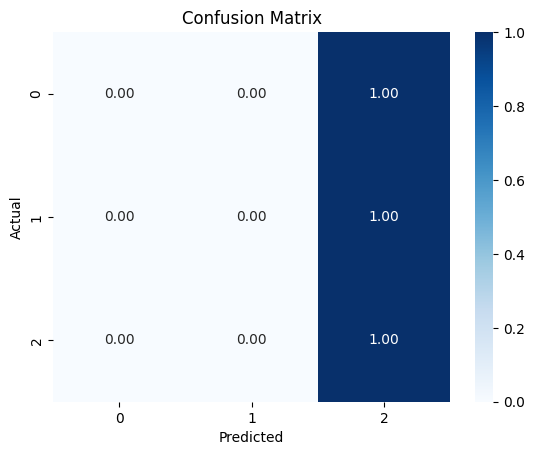

In [216]:
# training loop
import gc
import warnings
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.profilers import AdvancedProfiler

experimentDirectory = "n"
logDirectory = f"lightning_logs/{experimentDirectory}"

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message = r".*ill-defined and being set to 0.0")
                            
    for x in ExperimentModel.existingModels:
        
        try:
            os.mkdir(f"./lightning_logs/{x.name}")
            
        except FileExistsError:
            pass

        logDirectory = f"./lightning_logs/{x.name}"
        versionList = os.listdir(logDirectory)
        versionList.sort(key=lambda x: int(re.search(r'\d+', x).group()))

        try:
            buffer = int(re.search(r'\d+', versionList[-1]).group())
            versionToLog = (f'version_{buffer+1}')

        except IndexError:
            versionToLog = 'version_0'

        LOGPATH = r'/'.join([logDirectory,versionToLog]) # this is based on the tbLogger path scheme

        x.setLogPath(LOGPATH)
            
        gc.collect()
        torch.cuda.empty_cache()
        early_stopping = EarlyStopping(
            monitor='val_acc_F1_macro',  # Metric to monitor
            patience=10,          # Number of epochs with no improvement after which training will be stopped
            verbose=False,        # Verbosity mode
            mode='max'           # Mode can be 'min', 'max', or 'auto'
        )

        checkpoint_callback = ModelCheckpoint(dirpath=LOGPATH, save_top_k=1, monitor="val_acc_F1_macro",mode='max') #idk why but no, checkpoint_callback cannot infer logPath from tblogger

        profiler = AdvancedProfiler(dirpath=LOGPATH, filename="profiler_logs")
        
        tbLogger = TensorBoardLogger("lightning_logs",name=f"{x.name}") 

        trainer = L.Trainer(
                            # profiler = "simple",
                            # profiler = profiler,
                            max_epochs = 75,
                            min_epochs = 30,
                            accelerator ='gpu', 
                            devices = 'auto', 
                            precision = '16-mixed',
                            logger = tbLogger,
                            callbacks = [early_stopping,checkpoint_callback],
                        )
        
        
        trainer.fit(model=x,train_dataloaders=(x.trainLoader if x.trainLoader != None else trainLoader),val_dataloaders=(x.valLoader if x.valLoader != None else valLoader))

        
        # trainer.test(model = x, dataloaders=(x.valLoader if x.valLoader != None else valLoader))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.54      0.70      0.61        10
           2       0.71      0.50      0.59        10

    accuracy                           0.70        30
   macro avg       0.72      0.70      0.70        30
weighted avg       0.72      0.70      0.70        30



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.699999988079071     │
│     val_acc_F1_macro      │     0.698976993560791     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc_F1_macro': 0.698976993560791, 'val_acc': 0.699999988079071}]

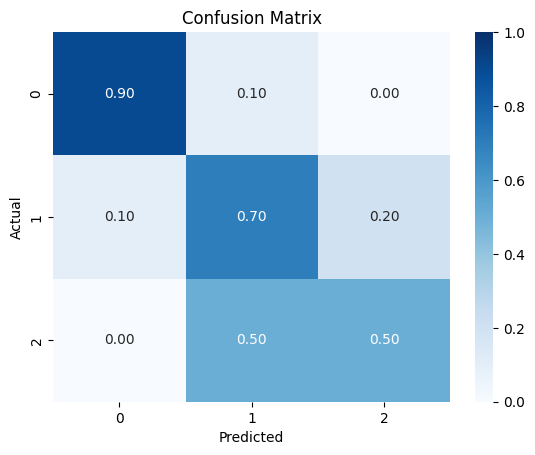

In [188]:
trainer.test(model = ExperimentModel.existingModels[0], dataloaders=valLoader)

In [187]:
valDataset = OsteoSetWithPatientDetails(valPathList,valLabelList,valTransform)
valLoader = DataLoader(valDataset, batch_size = 8,shuffle=False,num_workers=0)
vgg193.name = 'ckptTesst'
[x for x in valLoader]

[[[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             ...,
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.]],
   
            [[-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             ...,
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.]],
   
            [[-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             ...,
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.],
             [-1., -1., -1.,  ..., -1., -1., -1.]]],
   
   
        

In [ ]:
raise AssertionError("Training Complete")

In [ ]:
index = -1
[x.name for x in ExperimentModel.existingModels]

In [ ]:
import os 
import re 
index += 1
models = [x.name for x in ExperimentModel.existingModels][index]
logDirectory = f"./lightning_logs/{models}"
# logDirectory = f"./lightning_logs/VGGModelMax"
versionList = os.listdir(logDirectory)
versionList.sort(key=lambda x: int(re.search(r'\d+', x).group()))
# print(versionList[-1])
tbDir = f"{logDirectory}/{versionList[-1]}"
port = f'610{index}'

print(index)
!echo $tbDir
!taskkill /F /IM tensorboard.exe    
%load_ext tensorboard
%tensorboard --logdir $tbDir --port=$port

In [ ]:
[x.name for x in ExperimentModel.existingModels]

# GradCam Visualization

In [ ]:

import torch
model = torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True)
resnetPath = r'C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\tb_logs\ResnetModel\version_22\checkpoints'
resnet101 = ResnetModel.load_from_checkpoint('\\'.join([resnetPath,os.listdir(resnetPath)[-1]]),resnet = model)
torch.cuda.empty_cache()
resnet101.to(device = torch.device('cuda'))
# out,label = resnet50.visualize(valLoader)
resnet101.on_validation_epoch_end()

In [ ]:
torch.cuda.empty_cache()
model = VGGModel.load_from_checkpoint(r'tb_logs\VGGModel\version_26\checkpoints\epoch=19-step=720.ckpt',vgg = torchvision.models.vgg19(pretrained=False))
outvgg,path = model.visualize(valLoader)

plt.imshow(outvgg[0])

In [26]:
model = vgg193


# Classic pytorch for debugging

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
# Define the loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.204, 0.052, 0.175],device='cuda'))

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the device to GPU if available
device = torch.device("cuda")

# Move the model to the device
model = model.to(device)

# Set the model to training mode
model.train()

num_epochs = 25

accHistory = []
lossHistory = []
valAccHistory = []
valLabs = []
valPreds = []
print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = []
    
    # Iterate over the training dataset
    for inputs, labels, _ in trainLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        print(inputs.shape)
        # Forward pass
        outputs = model(inputs.float())
        predicted_labels = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)
        running_accuracy.append(accuracy)
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(trainLoader)}")
    print(F"Accuracy: {sum(running_accuracy)/len(running_accuracy)}")
    accHistory.append(sum(running_accuracy)/len(running_accuracy))
    lossHistory.append(running_loss / len(trainLoader))

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        
        runningValAccHistory = []
        runningValLabs = []
        runningValPreds = []
        for inputs, labels, _ in valLoader:

            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs.float())

            # Compute the loss
            loss = criterion(outputs, labels)

            # Compute the predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            # Compute the accuracy
            accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

            runningValAccHistory.append(accuracy)
            runningValLabs.append(labels)
            runningValPreds.append(predicted_labels)

        # print(f"Validation Loss: {loss.item()}")
        valPreds.append(runningValPreds)
        valLabs.append(runningValLabs)
        print(f"Validation Accuracy: {sum(runningValAccHistory)/len(valLoader)}")
        valAccHistory.append(sum(runningValAccHistory)/len(valLoader))

In [ ]:
import seaborn as sns
idx = 25
predsTest = torch.cat(valPreds[idx-1])
labelsTest = torch.cat(valLabs[idx-1])
print(valAccHistory[idx-1])
print(classification_report(predsTest.cpu(),labelsTest.cpu()))
cm= confusion_matrix(predsTest.cpu(),labelsTest.cpu(),normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# Create a dataframe with the data
df = pd.DataFrame({'Epoch': range(len(accHistory)), 'Accuracy': accHistory, 'Loss': lossHistory, 'Validation Accuracy': valAccHistory})

# Create the line plot
sns.relplot(data=df, x='Epoch', y='Accuracy', kind='line')
sns.relplot(data=df, x='Epoch', y='Loss', kind='line')
sns.relplot(data=df, x='Epoch', y='Validation Accuracy', kind='line')